In [1]:
import pandas as pd
import ast
import random
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [2]:
file_path = r"C:\Users\Laptop World\Desktop\NLPPROJECT\train_cleaned_with_sentences.csv"
df = pd.read_csv(file_path)
print(f"Dataset loaded: {len(df):,} descriptions")

Dataset loaded: 120,000 descriptions


In [3]:
df

,Class Index,Clean_Title,Clean_Sentences
0,3,wall st bear claw back black reuters,['reuters shortsellers wall street dwindlingba...
1,3,carlyle look toward commercial aerospace reuters,['reuters private investment firm carlyle grou...
2,3,oil economy cloud stock outlook reuters,['reuters soaring crude price plus worriesabou...
3,3,iraq halt oil export main southern pipeline re...,['reuters authority halted oil exportflows mai...
4,3,oil price soar alltime record posing new menac...,['afp tearaway world oil price toppling record...
...,...,...,...
119995,1,pakistan musharraf say wont quit army chief,['karachi reuters pakistani president pervez m...
119996,2,renteria signing topshelf deal,['red sox general manager theo epstein acknowl...
119997,2,saban going dolphin yet,['miami dolphin put courtship lsu coach nick s...
119998,2,today nfl game,['pittsburgh ny giant time pm line steelers re...


In [4]:
#Convert Clean_Sentences to real lists
def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

df['Sentences_List'] = df['Clean_Sentences'].apply(safe_eval)

In [5]:
df

,Class Index,Clean_Title,Clean_Sentences,Sentences_List
0,3,wall st bear claw back black reuters,['reuters shortsellers wall street dwindlingba...,[reuters shortsellers wall street dwindlingban...
1,3,carlyle look toward commercial aerospace reuters,['reuters private investment firm carlyle grou...,[reuters private investment firm carlyle group...
2,3,oil economy cloud stock outlook reuters,['reuters soaring crude price plus worriesabou...,[reuters soaring crude price plus worriesabout...
3,3,iraq halt oil export main southern pipeline re...,['reuters authority halted oil exportflows mai...,[reuters authority halted oil exportflows main...
4,3,oil price soar alltime record posing new menac...,['afp tearaway world oil price toppling record...,[afp tearaway world oil price toppling record ...
...,...,...,...,...
119995,1,pakistan musharraf say wont quit army chief,['karachi reuters pakistani president pervez m...,[karachi reuters pakistani president pervez mu...
119996,2,renteria signing topshelf deal,['red sox general manager theo epstein acknowl...,[red sox general manager theo epstein acknowle...
119997,2,saban going dolphin yet,['miami dolphin put courtship lsu coach nick s...,[miami dolphin put courtship lsu coach nick sa...
119998,2,today nfl game,['pittsburgh ny giant time pm line steelers re...,[pittsburgh ny giant time pm line steelers rec...


In [6]:
# Flatten all sentences (filter for 3+ words for Trigram)
all_sentences = []
for sentence_list in df['Sentences_List']:
    for sent in sentence_list:
        if isinstance(sent, str):
            sent = sent.strip()
            if len(sent.split()) >= 3:  # At least 3 words for Trigram
                all_sentences.append(sent)

print(f"Total sentences with 3+ words: {len(all_sentences):,}")

Total sentences with 3+ words: 148,706


In [7]:
#Build Unigram, Bigram, Trigram counters
unigram_counter = Counter()
bigram_counter  = Counter()
trigram_counter = Counter()

for sentence in all_sentences:
    words = sentence.split()
    # Unigram (N=1)
    unigram_counter.update(words)
    
    # Bigram (N=2)
    for i in range(len(words) - 1):
        bigram_counter[(words[i], words[i+1])] += 1
    
    # Trigram (N=3)
    for i in range(len(words) - 2):
        trigram_counter[(words[i], words[i+1], words[i+2])] += 1
V = len(unigram_counter)
total_words = sum(unigram_counter.values())

print(f"Vocabulary size (V): {V:,}")
print(f"Unique unigrams: {len(unigram_counter):,}")
print(f"Unique bigrams: {len(bigram_counter):,}")
print(f"Unique trigrams: {len(trigram_counter):,}")

Vocabulary size (V): 77,791
Unique unigrams: 77,791
Unique bigrams: 1,019,564
Unique trigrams: 1,514,377


In [8]:
# Probability functions for Unigram, Bigram, Trigram
def unigram_prob(word):
    """P(word) = (count(word) + 1) / (total_words + V)"""
    return (unigram_counter.get(word, 0) + 1) / (total_words + V)

def bigram_prob(w1, w2):
    return (bigram_counter.get((w1, w2), 0) + 1) / (unigram_counter.get(w1, 0) + V)

def trigram_prob(w1, w2, w3):
    return (trigram_counter.get((w1, w2, w3), 0) + 1) / (bigram_counter.get((w1, w2), 0) + V)

def sentence_unigram_prob(sentence):
    """P(sentence) = P(w1) * P(w2) * ... (independent words)"""
    words = sentence.split()
    if not words:
        return 0.0
    prob = 1.0
    for word in words:
        prob *= unigram_prob(word)
    return prob

def sentence_bigram_prob(sentence):
    words = sentence.split()
    if len(words) < 2:
        return 0.0
    prob = unigram_prob(words[0])
    for i in range(1, len(words)):
        prob *= bigram_prob(words[i-1], words[i])
    return prob

def sentence_trigram_prob(sentence):
    words = sentence.split()
    if len(words) < 3:
        return 0.0
    prob = unigram_prob(words[0])
    prob *= bigram_prob(words[0], words[1])
    for i in range(2, len(words)):
        prob *= trigram_prob(words[i-2], words[i-1], words[i])
    return prob

In [10]:
# Sample 10 random sentences and compute all probabilities
random.seed(42)
sample_sentences = random.sample(all_sentences, 10)

comparison_results = []
for sent in sample_sentences:
    p_unigram = sentence_unigram_prob(sent)
    p_bigram  = sentence_bigram_prob(sent)
    p_trigram = sentence_trigram_prob(sent)
    comparison_results.append({
        'Sentence': sent,
        'Unigram_Prob': p_unigram,
        'Bigram_Prob': p_bigram,
        'Trigram_Prob': p_trigram
    })

# Sort by Trigram probability (highest to lowest)
comparison_results.sort(key=lambda x: x['Trigram_Prob'], reverse=True)

In [14]:
# Display comparison table
print("Unigram vs Bigram vs Trigram Probability Comparison (10 Random Sentences)")
print(f"{'#':<3} {'Unigram':<15} {'Bigram':<15} {'Trigram':<15} {'Sentence'}")
for i, res in enumerate(comparison_results, 1):
    print(f"{i:<3} {res['Unigram_Prob']:<15.2e} {res['Bigram_Prob']:<15.2e} {res['Trigram_Prob']:<15.2e} {res['Sentence']}")

Unigram vs Bigram vs Trigram Probability Comparison (10 Random Sentences)
#   Unigram         Bigram          Trigram         Sentence
1   1.73e-56        3.33e-55        8.76e-58        saif saaeed shaheen qatar set world record steeplechase van damme memorial meet friday
2   5.76e-51        9.93e-57        5.81e-62        italian airline alitalia agreed deal ground staff paving way job cut reduction staff benefit
3   1.59e-55        5.98e-56        5.53e-62        paris france sport network ac milan ukraine striker andriy shevchenko named european footballer year monday
4   4.23e-55        8.86e-58        1.81e-65        former fannie mae employee assisted federal regulator investigation company accounting testify congressional hearing next week
5   8.76e-62        9.83e-71        1.30e-76        union negotiator today claimed close agreeing pay deal british airway avoid bank holiday strike resulting travel chaos
6   2.03e-86        7.42e-84        4.90e-85        ap texas comptrolle

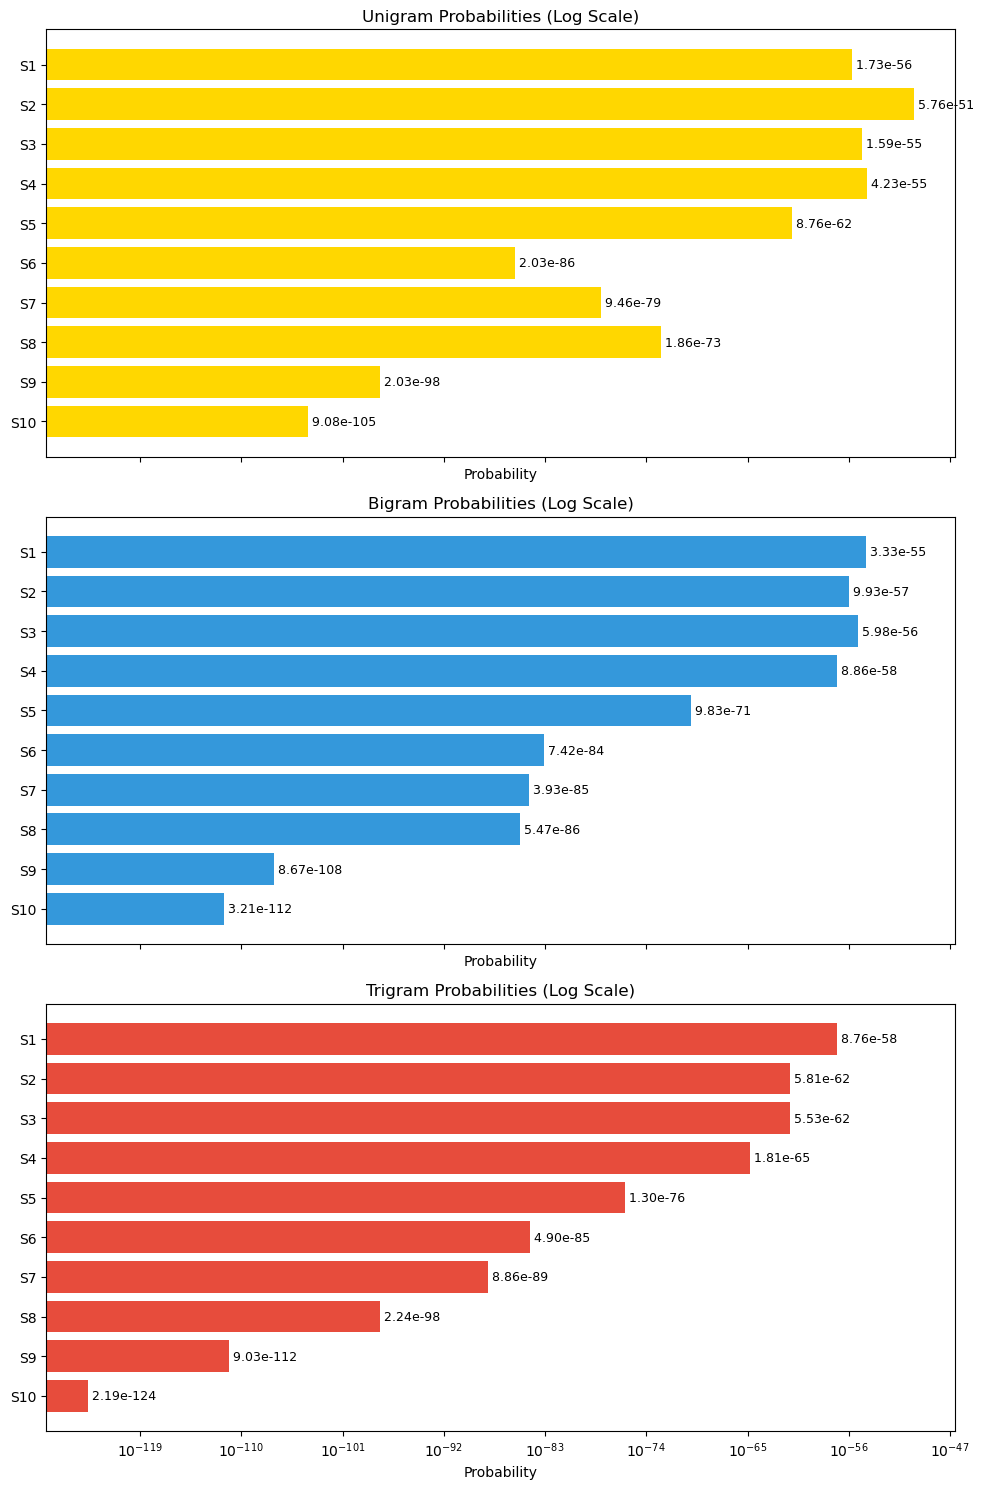

In [15]:
#  Visualization – Separate Bar Charts for each model
models = ['Unigram', 'Bigram', 'Trigram']
probs = {
    'Unigram': [res['Unigram_Prob'] for res in comparison_results],
    'Bigram': [res['Bigram_Prob'] for res in comparison_results],
    'Trigram': [res['Trigram_Prob'] for res in comparison_results]
}
sent_labels = [f"S{i+1}" for i in range(len(comparison_results))]

fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

for idx, model in enumerate(models):
    ax = axes[idx]
    ax.barh(sent_labels, probs[model], color=['#FFD700', '#3498db', '#e74c3c'][idx])
    ax.set_title(f"{model} Probabilities (Log Scale)")
    ax.set_xscale('log')
    ax.set_xlabel('Probability')
    ax.invert_yaxis()
    
    # Add values on bars
    for i, p in enumerate(probs[model]):
        ax.text(p, i, f' {p:.2e}', va='center', ha='left', fontsize=9)
plt.tight_layout()
plt.show()

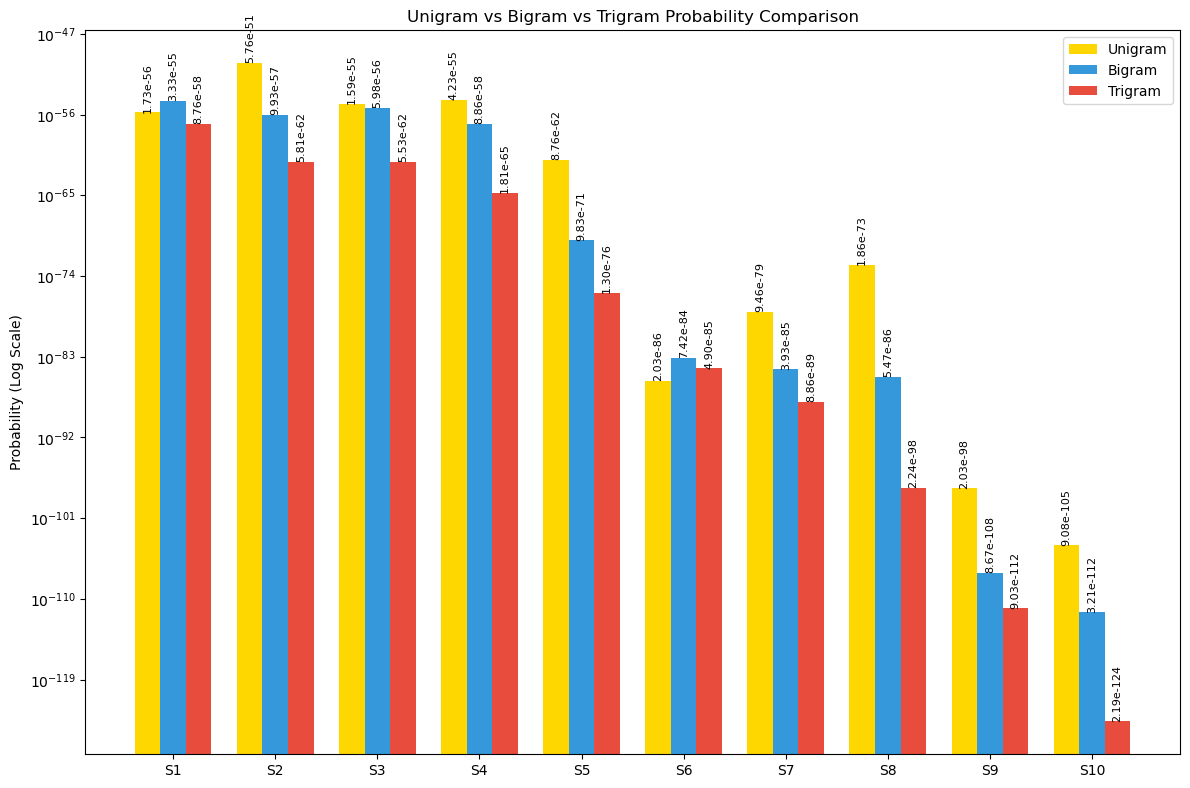

In [16]:
#Visualization – Grouped Bar Chart for comparison

fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(sent_labels))
width = 0.25

# Create grouped bars
bars1 = ax.bar(x - width, [res['Unigram_Prob'] for res in comparison_results], width, label='Unigram', color='#FFD700')
bars2 = ax.bar(x, [res['Bigram_Prob'] for res in comparison_results], width, label='Bigram', color='#3498db')
bars3 = ax.bar(x + width, [res['Trigram_Prob'] for res in comparison_results], width, label='Trigram', color='#e74c3c')

ax.set_yscale('log')
ax.set_ylabel('Probability (Log Scale)')
ax.set_title('Unigram vs Bigram vs Trigram Probability Comparison')
ax.set_xticks(x)
ax.set_xticklabels(sent_labels)
ax.legend()

# Add values on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2e}', ha='center', va='bottom', fontsize=8, rotation=90)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.tight_layout()
plt.show()